## Bibliotecas 

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Treinamento pré-processamento

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normaliza as imagens, dividindo cada valor de pixel por 255 (escala de 0 a 1)
    shear_range=0.2,            # Aplica uma transformação de cisalhamento aleatória com um máximo de 20% (modifica a geometria da imagem)
    zoom_range=0.2,             # Aplica zoom aleatório em até 20% (aumentando ou diminuindo a imagem)
    horizontal_flip=True,       # Realiza uma inversão horizontal aleatória da imagem (espelhamento)
    rotation_range=20,          # Rotaciona a imagem aleatoriamente em até 20 graus
    width_shift_range=0.2,      # Aplica uma translação horizontal aleatória de até 20% da largura da imagem
    height_shift_range=0.2,     # Aplica uma translação vertical aleatória de até 20% da altura da imagem
    fill_mode='nearest'         # Preenche os espaços vazios criados por transformações (como rotação ou translação) com os valores dos pixels mais próximos
)
train_set = train_datagen.flow_from_directory(
    'faces/train/',
    target_size=(128, 128),   
    batch_size=32,
    class_mode='categorical'       
)

Found 29 images belonging to 3 classes.


## Teste pré-processamento

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    'faces/test/',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 14 images belonging to 3 classes.


## Rede Neural

In [9]:
# weights Especifica que os pesos do modelo devem ser carregados de um treinamento prévio no banco de dados 
# include_top=False Indica que a parte superior do modelo (a camada de saída da rede projetada para a classificação de 1.000 classes no ImageNet) será removida.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Congelar
base_model.trainable = False

model = Sequential([
    base_model,                      # Modelo pré-treinado
    Flatten(),                       # Achatar a saída do modelo base
    Dense(512, activation='relu'),   # Camada densa com 512 neurônios
    Dropout(0.5),                    # Dropout para evitar overfitting
    Dense(3, activation='softmax')   # Camada final com 3 classes (softmax)
])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,486,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,745,795 (48.62 MB)

 Trainable params: 10,487,811 (40.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Treinamendo do modelo

In [12]:
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitorar a perda (loss) no conjunto de validação
    patience=5,                  # Número de épocas sem melhoria antes de interromper o treinamento
    restore_best_weights=True   # Restaura os pesos do modelo para os melhores encontrados durante o treinamento
)

In [14]:
history = model.fit(x = train_set, validation_data = test_set, epochs = 30, callbacks=[early_stopping])

Epoch 1/30


C:\Users\Gabriel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2759 - loss: 1.9462 - val_accuracy: 0.4286 - val_loss: 5.9254
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.6207 - loss: 5.3271 - val_accuracy: 0.3571 - val_loss: 6.6979
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.4828 - loss: 6.2819 - val_accuracy: 0.4286 - val_loss: 13.8159
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5862 - loss: 7.4048 - val_accuracy: 0.5714 - val_loss: 11.2531
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7931 - loss: 2.8562 - val_accuracy: 0.5714 - val_loss: 4.4038
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7931 - loss: 3.8443 - val_accuracy: 0.9286 - val_loss: 0.4023
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8621 - loss: 2.3615 - val_accuracy: 0.9286 - val_loss: 0.1063
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7241 - loss: 4.3387 - val_accuracy: 0.7857 - val_loss: 0.7048
Epoc

## Resultados

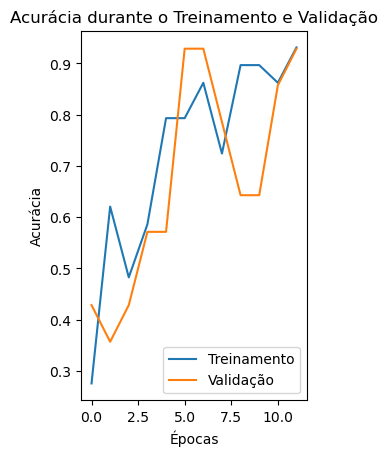

In [16]:
# Plotando Acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

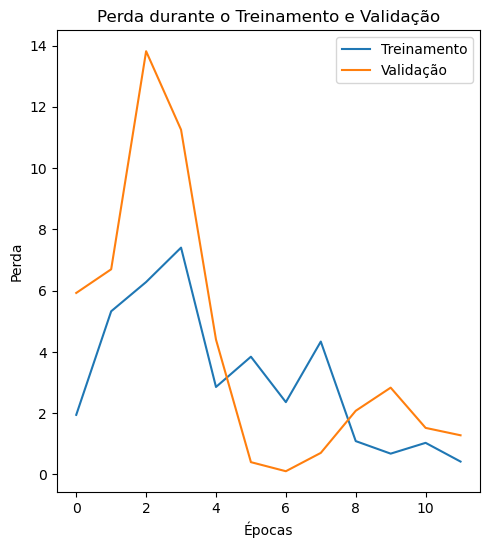

In [30]:
# Plotando Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

In [22]:
x_test = []
y_test = []

for images, labels in test_set:  # test_set é o gerador de teste
    x_test.extend(images)        # Adicionar imagens
    y_test.extend(labels)        # Adicionar rótulos
    
    # Parar quando todos os dados forem carregados
    if len(x_test) >= test_set.samples:
        break

x_test = np.array(x_test)
y_test = np.array(y_test)

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_test shape: (14, 128, 128, 3)
y_test shape: (14, 3)


In [24]:
y_pred_prob = model.predict(x_test)  # Previsões em forma de probabilidades

# Converter probabilidades para classes
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Para múltiplas classes (softmax)
y_test_classes = np.argmax(y_test, axis=1)       # Converter y_test de one-hot para classes

print(f"Previsões: {y_pred_classes}")
print(f"Rótulos verdadeiros: {y_test_classes}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Previsões: [2 1 2 2 2 1 1 1 1 0 0 2 1 0]
Rótulos verdadeiros: [2 0 2 2 2 1 1 1 1 0 0 2 1 0]


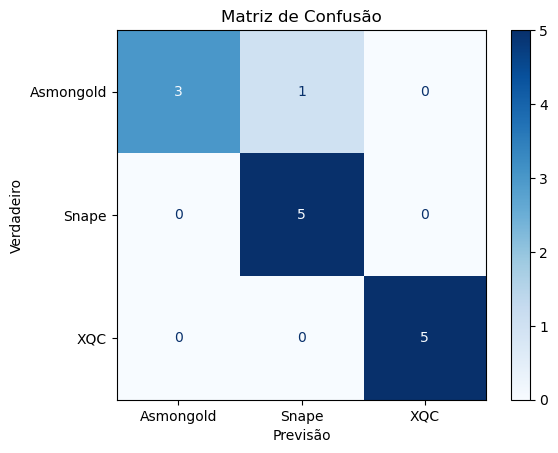

In [26]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_set.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.xlabel("Previsão")  
plt.ylabel("Verdadeiro") 
plt.show()

In [50]:
max_accuracy = max(history.history['accuracy'])
print(f"Acurácia Máxima: {max_accuracy * 100:.2f}%")

Acurácia Máxima: 93.10%
